In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad

from tqdm import tqdm
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reproduction
np.random.seed(1)
torch.manual_seed(1)

print('Python version: ', sys.version)
print('PyTorch version: ', torch.__version__)

Python version:  3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
PyTorch version:  2.0.1+cu118


In [3]:
class SineWaveGenerator():
  """
  a: amplitude
  b: phase

  sample_task(self, K=10): sample K points
  plot: plot sine wave
  """

  def __init__(self, amplitude=None, phase=None):
    self.a = amplitude if amplitude else np.random.uniform(0.1, 5.0)
    self.b = phase if phase else np.random.uniform(0, np.pi)

  @torch.no_grad()
  def sample_task(self, K=10, side=None):
    p=-5
    q=5
    if side=="left":
      q=0
    if side=="right":
      p=0
    x = np.random.uniform(p, q, K)  # Sample x in [-5, 5] interval
    y = self.a * np.sin(x - self.b)
    loss_fct = nn.MSELoss()
    return torch.Tensor(x).reshape(K,1), torch.Tensor(y).reshape(K,1), loss_fct

  def plot(self, K=100, *args, **kwargs):
    x = np.linspace(-5, 5, K)
    y = self.a * np.sin(x - self.b)
    return plt.plot(x, y, *args, **kwargs)

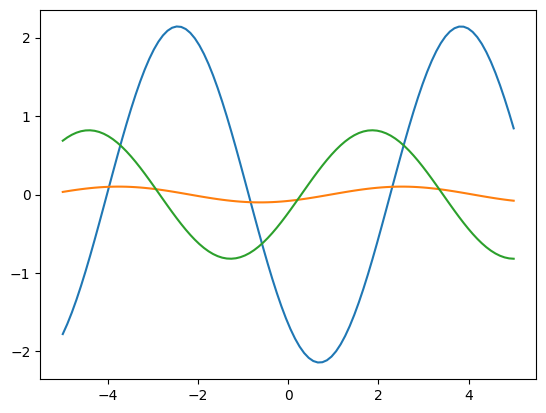

In [4]:
SineWaveGenerator().plot()
SineWaveGenerator().plot()
SineWaveGenerator().plot()
plt.show()

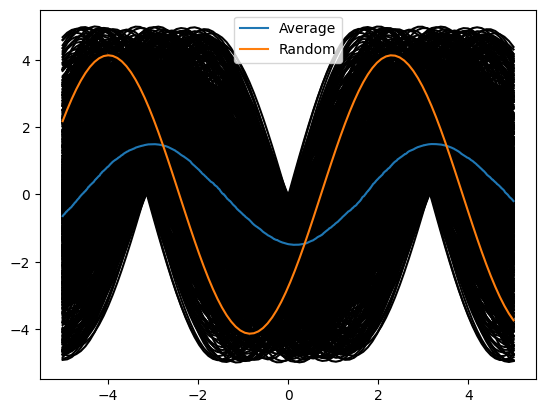

In [5]:
all_x, all_y = [], []

for _ in range(1000):
    SineWaveGenerator().plot(color='black')

for _ in range(100):
  t = SineWaveGenerator()
  curx, _, _ = t.sample_task(K=10000)
  curx = np.sort(curx.numpy().T).flatten()
  cury = t.a*np.sin(curx-t.b)

  all_x.append(curx)
  all_y.append(cury)

avg, = plt.plot(all_x[0], np.mean(all_y, axis=0))
rand, = SineWaveGenerator().plot()
plt.legend([avg, rand], ['Average', 'Random'])
plt.show()

In [6]:
def generate_dataset(train_size=20000, test_size=10):
    '''Generate train and test dataset.

    A dataset is composed of SineWaveGenerators that are able to provide
    a batch of K elements at a time.
    '''
    def _generate_dataset(size):
        return [SineWaveGenerator() for _ in range(size)]

    return _generate_dataset(train_size), _generate_dataset(test_size)

train_ds, test_ds = generate_dataset()

In [ ]:
device = "cpu"

def mlp(x, params):
  h = torch.relu(torch.nn.functional.linear(x, params[0], bias=params[1]))
  h = torch.relu(torch.nn.functional.linear(h, params[2], bias=params[3]))
  return torch.nn.functional.linear(h, params[4], bias=params[5])

def init_params():
  return [torch.rand(40, 1, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
                torch.zeros(40, device=device).requires_grad_(),
                torch.rand(40, 40, device=device).uniform_(-np.sqrt(6. / 80), np.sqrt(6. / 80)).requires_grad_(),
                torch.zeros(40, device=device).requires_grad_(),
                torch.rand(1, 40, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
                torch.zeros(1, device=device).requires_grad_()]

def train_model (dataset, model_params, epochs=1, lr=0.01):
  optimizer = torch.optim.Adam(model_params, lr)
  losses = []
  total_loss=0
  j = 0
  for epoch in range(epochs):
    for i, sinusoid_generator in tqdm(enumerate(dataset)):
      x, y, loss_fct = sinusoid_generator.sample_task(K=10)
      loss = loss_fct(mlp(x.to(device), model_params), y.to(device))
      total_loss += loss
      curr_loss = total_loss / (j + 1.0)
      losses.append(curr_loss.detach())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      j +=1

  plt.plot(losses)
  plt.title('Loss Vs Time steps')
  plt.show()
  return model_params

20000it [00:24, 832.24it/s]


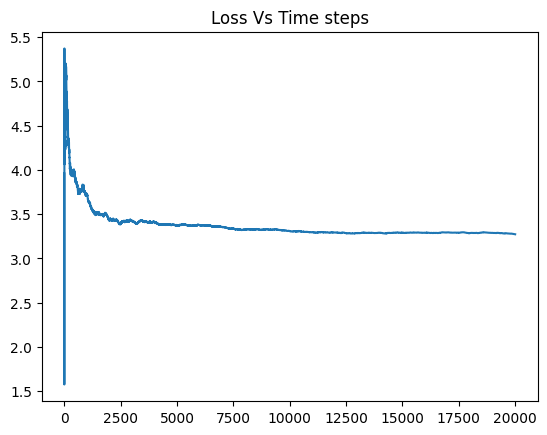

In [ ]:
nn_params = init_params()
nn_params = train_model(train_ds, model_params=nn_params, epochs=1, lr=0.01)

In [ ]:
def cmp_model_to_avg(dataset, model_params, model_name='Neural_Net', K=10):
  avg_pred = []
  x = np.linspace(-5, 5, K)
  for i, sin_gen in enumerate(dataset):
    y = sin_gen.a * np.sin(x - sin_gen.b)
    avg_pred.append(y)

  avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0), '--')

  model_pred = mlp(torch.Tensor(x).reshape(K,1).to(device), model_params)
  model_plot, = plt.plot(x, model_pred.detach().numpy())

  plt.legend([avg_plot, model_plot], ['Avg', model_name])
  plt.show()

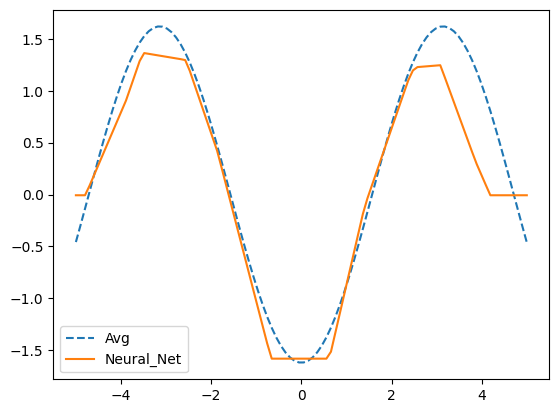

In [ ]:
cmp_model_to_avg(train_ds, nn_params, K=100)

In [ ]:
def tune_model(model_params, sine_wave=None, sample = None, max_steps=10):
  steps = [i for i in range(max_steps+1)]
  if sine_wave is None:
    sine_wave = SineWaveGenerator()

  N_test = 100
  x_test = np.linspace(-5, 5, N_test)
  y_test = sine_wave.a * np.sin(x_test- sine_wave.b)

  x, y, loss_fct = sample
  optimizer = torch.optim.Adam(model_params, lr=0.01)

  tensor_x_test, tensor_y_test = torch.Tensor(x_test).reshape(N_test,1), torch.Tensor(y_test).reshape(N_test,1)

  step_results = []

  if 0 in steps:
    output = mlp(tensor_x_test.to(device), model_params)
    loss = loss_fct(output, tensor_y_test.to(device))
    step_results.append(
        (0,
         output.detach().numpy().flatten(),
         loss.detach().numpy().flatten()[0]
        )
    )

  for step in range(1, np.max(steps)+1):
    loss = loss_fct(mlp(x.to(device), model_params), y.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step in steps:
      step_results.append(
          (step,
           mlp(tensor_x_test.to(device), model_params).detach().numpy().flatten(),
           loss_fct(mlp(tensor_x_test.to(device), model_params),
                    tensor_y_test.to(device)).detach().numpy().flatten()[0]
          )
      )

  return model_params, step_results, x, y, x_test, y_test

In [ ]:
def plot_tuned(info, x, y, x_test, y_test, steps=[0,1,10]):
  train, = plt.plot(x, y, '^')
  ground_truth, = plt.plot(x_test, y_test)
  plots = [train, ground_truth]
  legend = ['trening tačke', 'stvarna funkcija']
  markers = [':', '--', '.-']
  i_marker = 0
  for n, res, loss in info:
    if n in steps:
      cur, = plt.plot(x_test, res, markers[i_marker], ms = 5.0)
      i_marker +=1
      plots.append(cur)
      legend.append(f'posle {n} koraka')
  plt.legend(plots, legend)
  plt.ylim(-5, 5)
  plt.xlim(-6, 6)
  plt.show()

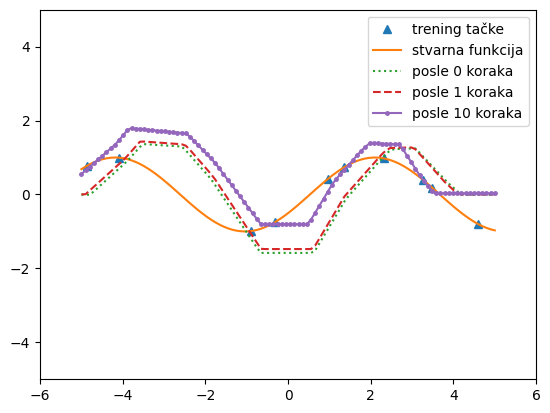

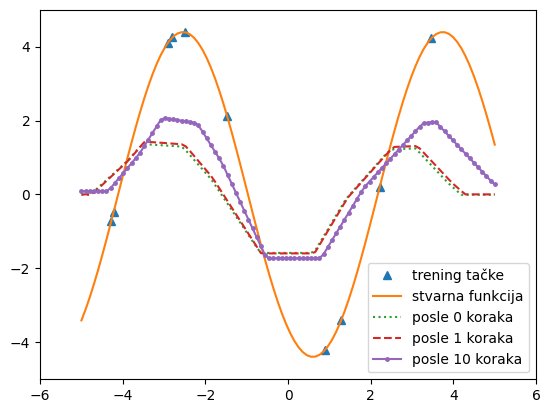

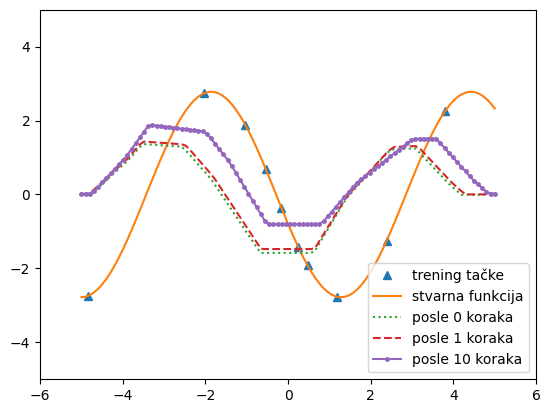

In [ ]:
for i in np.random.randint(0, len(test_ds), size=3):
  model_for_tuning = [torch.tensor(p.clone().detach().numpy(), requires_grad=True) for p in nn_params]
  tuned, info, x, y, x_test, y_test = tune_model(model_for_tuning, sine_wave=test_ds[i],
                                                 sample=test_ds[i].sample_task(K=10))
  plot_tuned(info, x, y, x_test, y_test)

In [ ]:
def perform_n_training_steps(model_params, task, batch_size, n_steps, alpha, device='cpu'):
    for epoch in range(n_steps):
        x, y, loss_fct = task.sample_task(K=batch_size)
        loss = loss_fct(mlp(x.to(device), model_params), y.to(device))

        for p in model_params:  # Zero grad
            p.grad = None
        gradients = grad(loss, model_params)
        for p, g in zip(model_params, gradients):  # Grad step
            p.data -= alpha * g
    return model_params

def maml(model_params, inner_training_steps, n_epochs, batch_size_K, alpha, n_tasks=10, device='cpu'):

    training_loss = []
    meta_optimizer = torch.optim.Adam(model_params, lr=0.01)
    total_loss = 0

    for epoch in tqdm(range(n_epochs)):  # Line 2 in the pseudocode

        theta_i_prime = []
        D_i_prime = []

        # Sample batch of tasks
        tasks = [SineWaveGenerator() for _ in range(n_tasks)]  # Line 3 in the pseudocode
        for task in tasks:
            theta_i_prime.append(perform_n_training_steps([p.clone() for p in model_params], task, batch_size_K,
                                                          inner_training_steps, alpha, device=device))
            # Sample data points Di' for the meta-update (line 8 in the pseudocode)
            x, y, loss_fct = task.sample_task(K=batch_size_K)
            D_i_prime.append((x, y, loss_fct))

        # Meta update
        meta_optimizer.zero_grad()
        batch_training_loss = []
        for i in range(n_tasks):
            x, y, loss_fct = D_i_prime[i]
            f_theta_prime = theta_i_prime[i]
            # Compute \nabla_theta L(f_theta_i_prime) for task ti
            loss = loss_fct(mlp(x.to(device), f_theta_prime), y.to(device))
            loss.backward()
            batch_training_loss.append(loss.item())

        meta_optimizer.step()  # Line 10 in the pseudocode

        total_loss += np.mean(batch_training_loss)
        curr_loss = total_loss / (epoch + 1.0)
        training_loss.append(curr_loss)

    plt.plot(training_loss)
    plt.title('Loss Vs Time steps')
    plt.show()

    return model_params

100%|██████████| 20000/20000 [04:07<00:00, 80.69it/s]


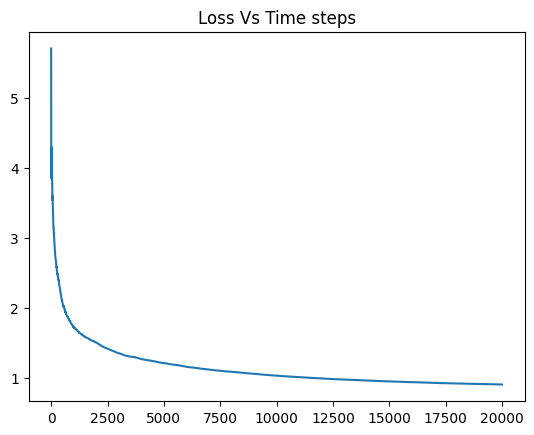

In [ ]:
maml_params = init_params()
maml_params = maml(maml_params, 1, 20_000, 10, alpha=0.01)

Pretrenirana neuronska mreža


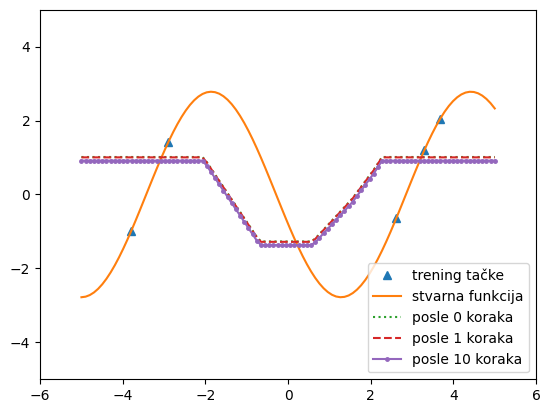

MAML


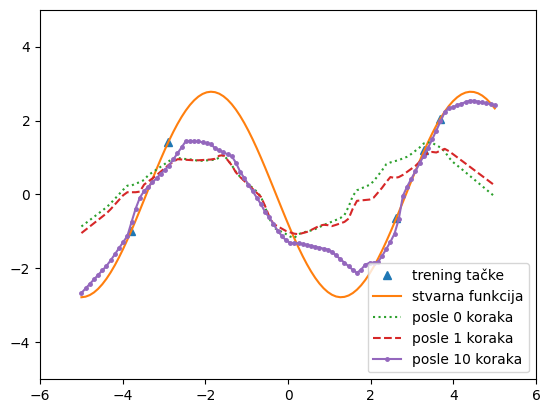

MSE comparison


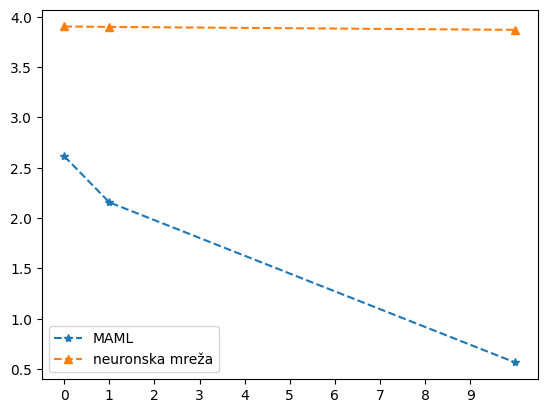





Pretrenirana neuronska mreža


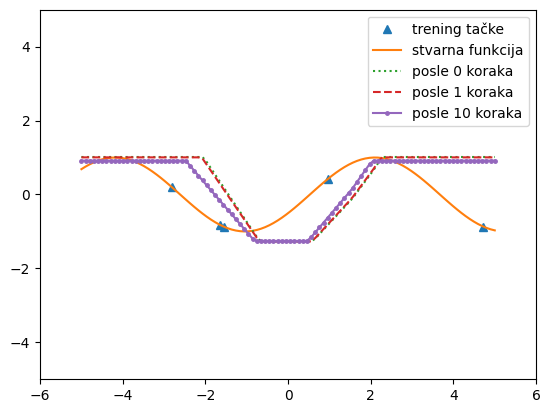

MAML


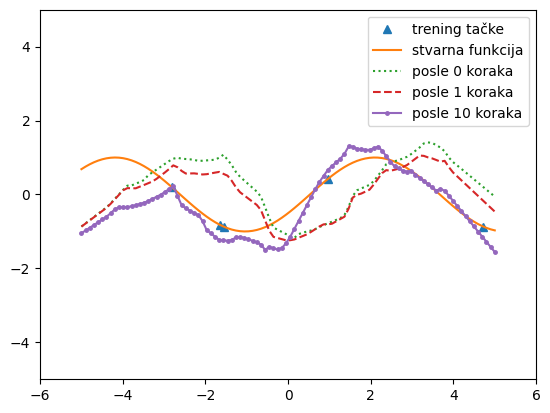

MSE comparison


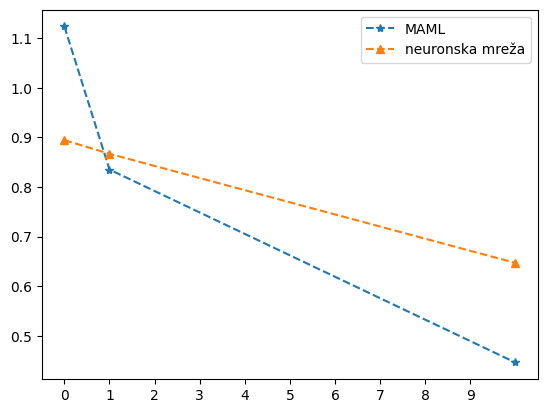





Pretrenirana neuronska mreža


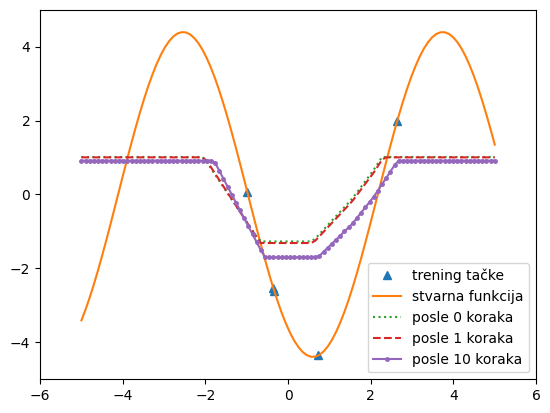

MAML


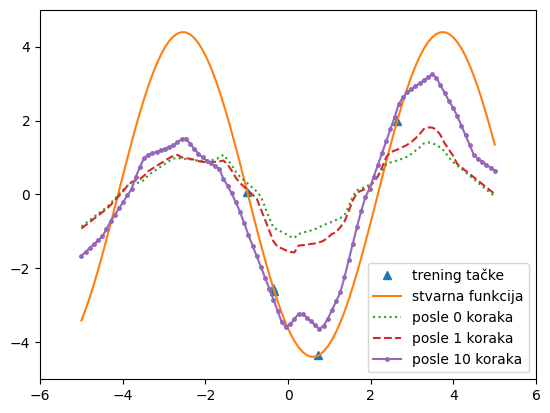

MSE comparison


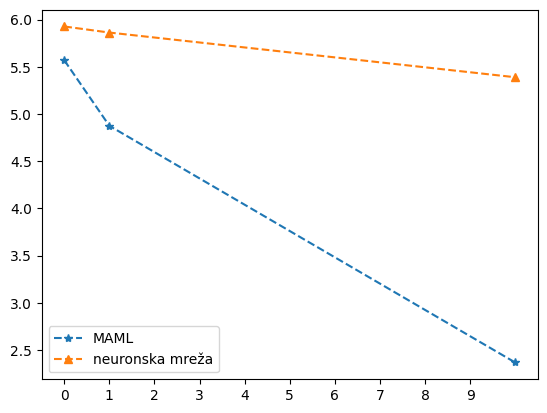





Pretrenirana neuronska mreža


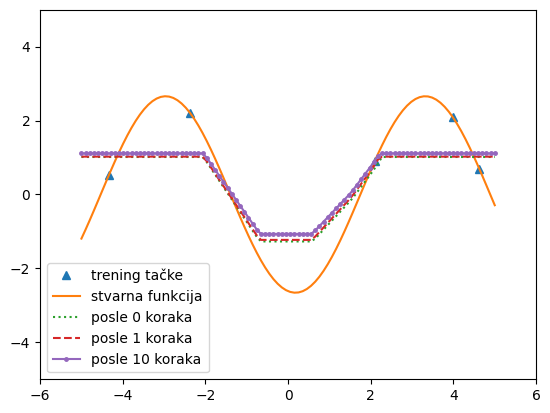

MAML


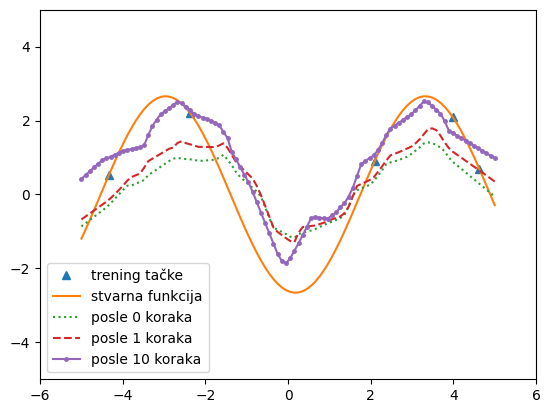

MSE comparison


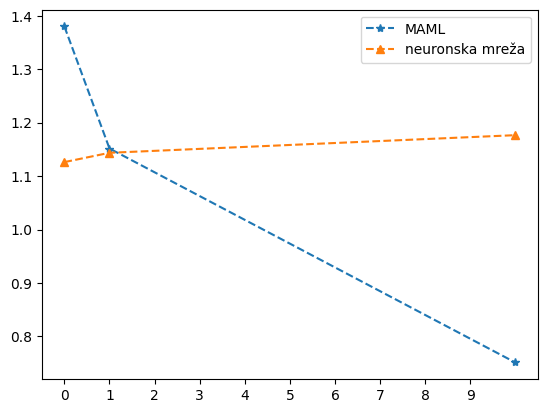





Pretrenirana neuronska mreža


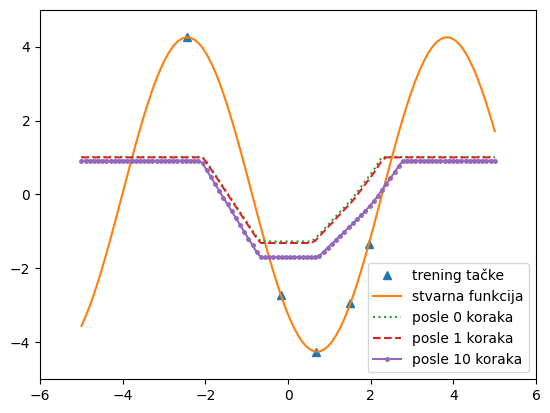

MAML


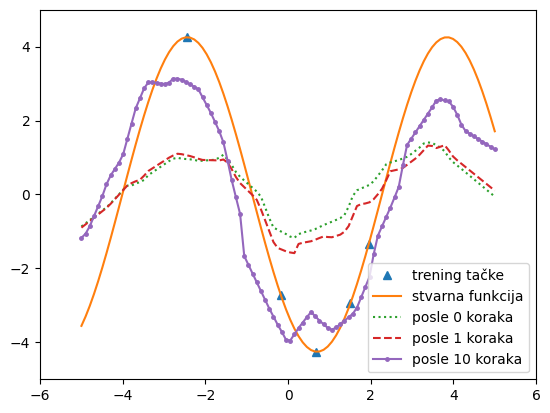

MSE comparison


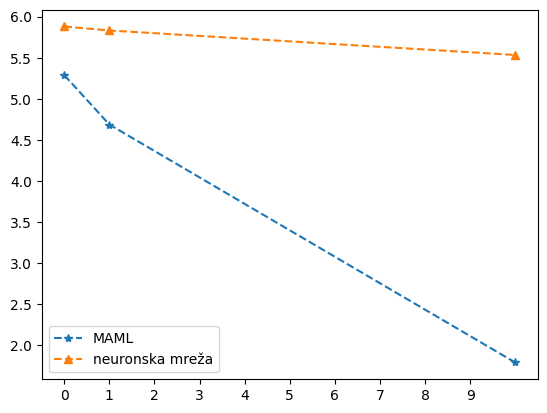





Pretrenirana neuronska mreža


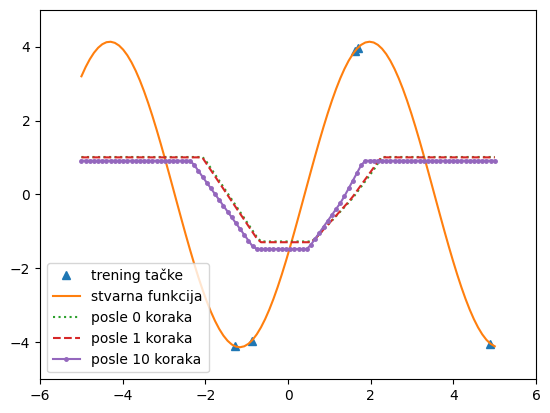

MAML


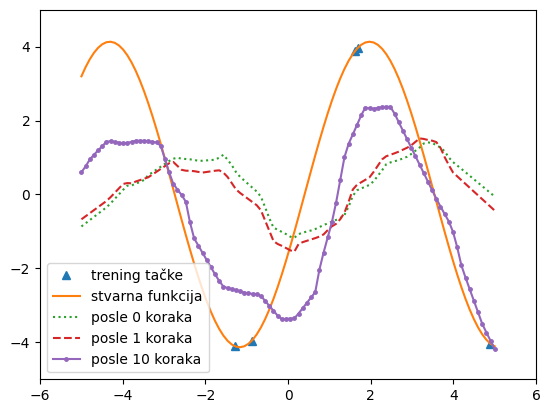

MSE comparison


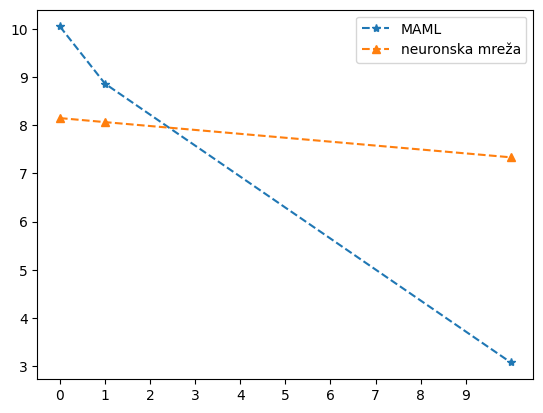





Pretrenirana neuronska mreža


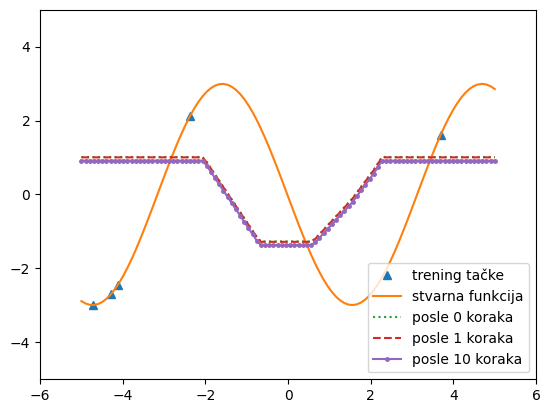

MAML


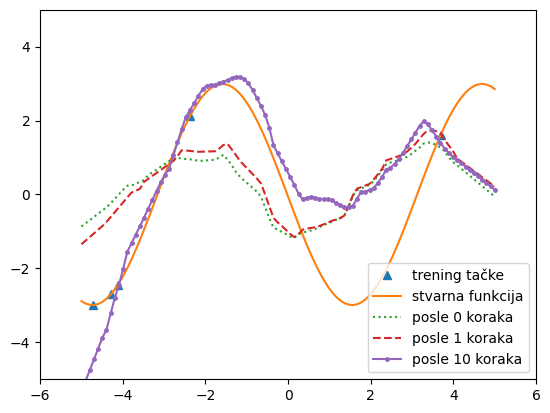

MSE comparison


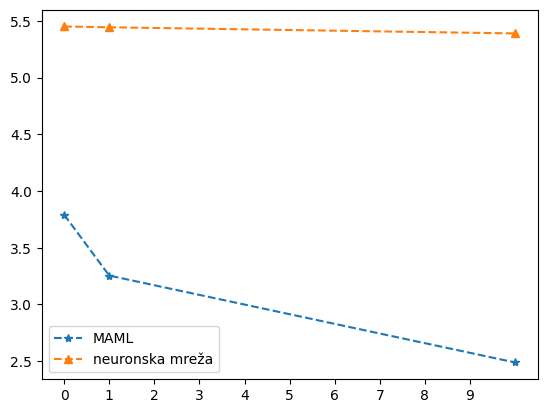





Pretrenirana neuronska mreža


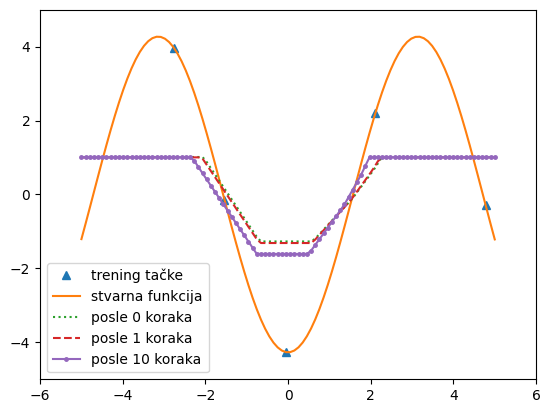

MAML


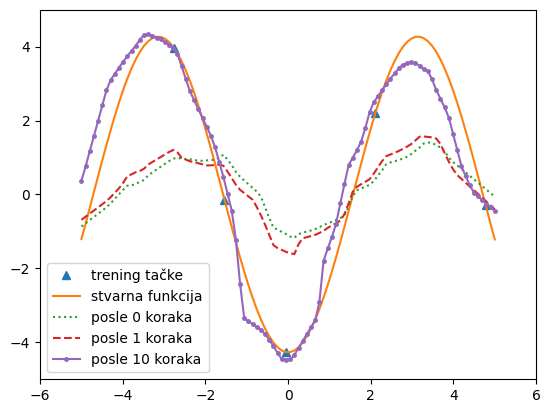

MSE comparison


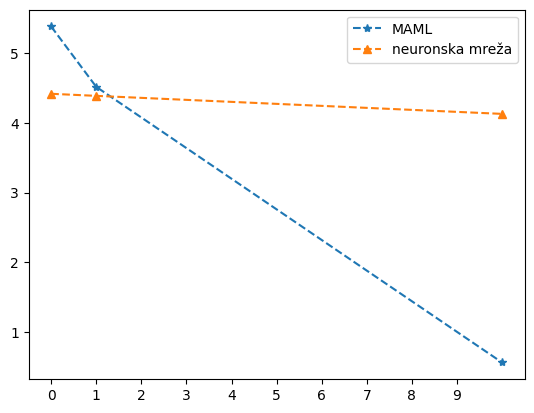





Pretrenirana neuronska mreža


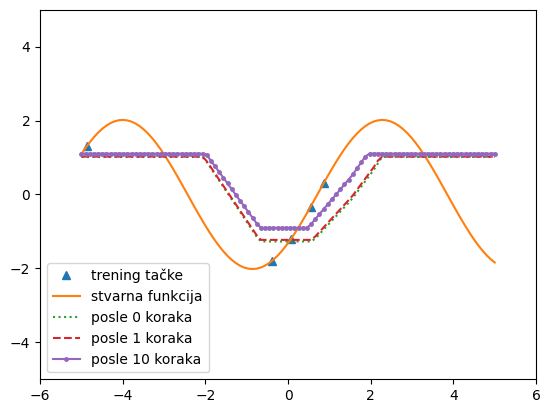

MAML


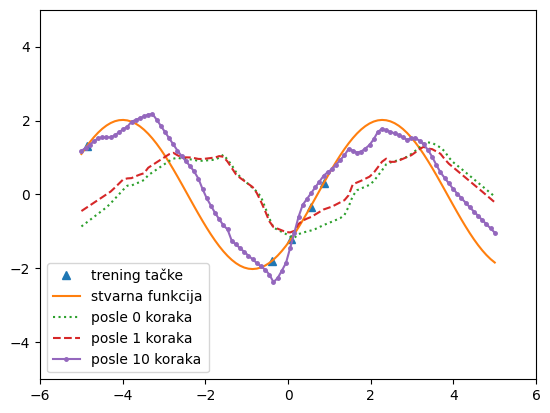

MSE comparison


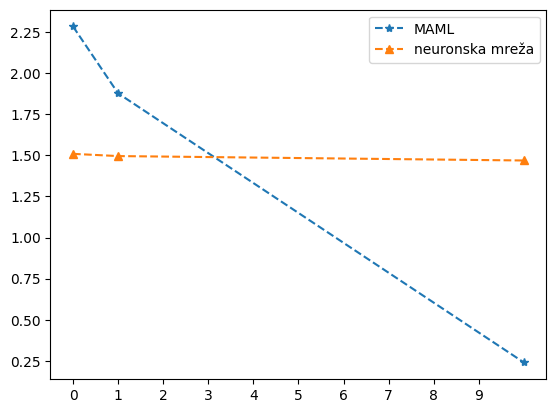





Pretrenirana neuronska mreža


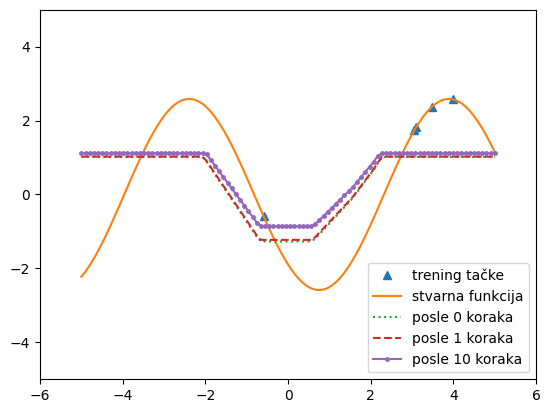

MAML


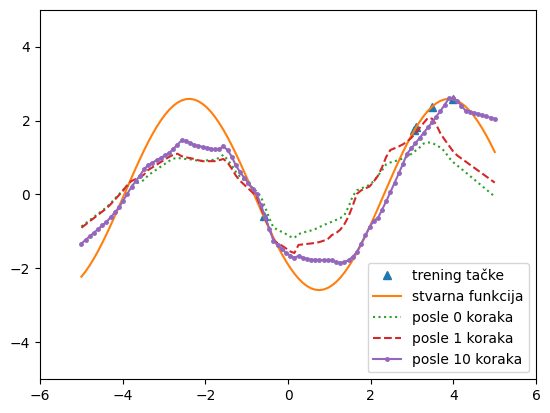

MSE comparison


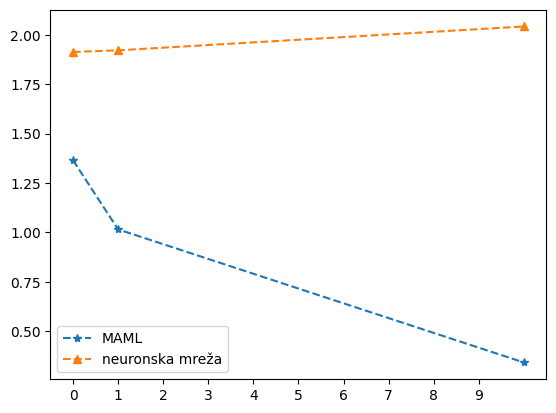

In [ ]:
for i in range(0, len(test_ds)):
  steps=[0,1,10]
  mft_nn = [torch.tensor(p.clone().detach().numpy(), requires_grad=True) for p in nn_params]
  mft_maml = [torch.tensor(p.clone().detach().numpy(), requires_grad=True) for p in maml_params]

  task_sample = test_ds[i].sample_task(K=10)

  tuned_nn, info_nn, x_nn, y_nn, x_test_nn, y_test_nn = tune_model(mft_nn, sine_wave=test_ds[i],
                                                                   sample=task_sample, max_steps=10)
  tuned_m, info_m, x_m, y_m, x_test_m, y_test_m = tune_model(mft_maml, sine_wave=test_ds[i],
                                                             sample=task_sample, max_steps=10)

  print("Pretrenirana neuronska mreža")
  plot_tuned(info_nn, x_nn, y_nn, x_test_nn, y_test_nn)
  print("MAML")
  plot_tuned(info_m, x_m, y_m, x_test_m, y_test_m)
  print("MSE comparison")
  fit_res = {'MAML': info_m, 'neuronska mreža': info_nn}
  legend = []
  num_steps=list(range(10))
  markers = ['*', '^']
  ind=0
  for name in fit_res:
    x = []
    y = []
    for n, _, loss in fit_res[name]:
      if n in steps:
        x.append(n)
        y.append(loss)
    plt.plot(x, y, marker=markers[ind], linestyle='--')
    plt.xticks(num_steps)
    ind+=1
    legend.append(name)
  plt.legend(legend)
  plt.show()
  print()
  print()
  print()
  print()

Neural Net


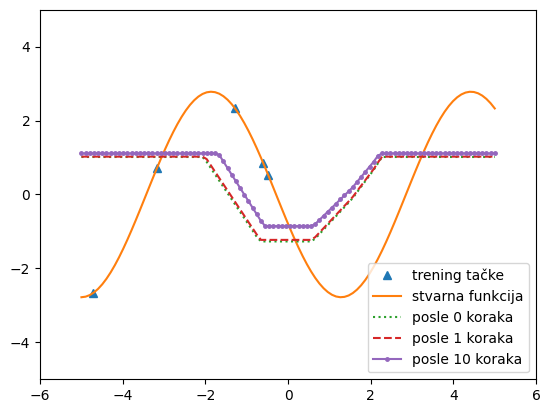

MAML


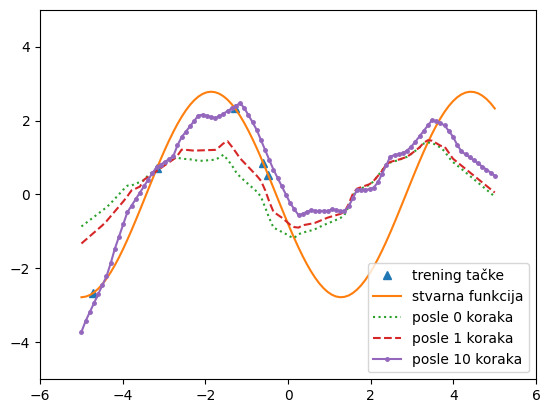

MSE comparison


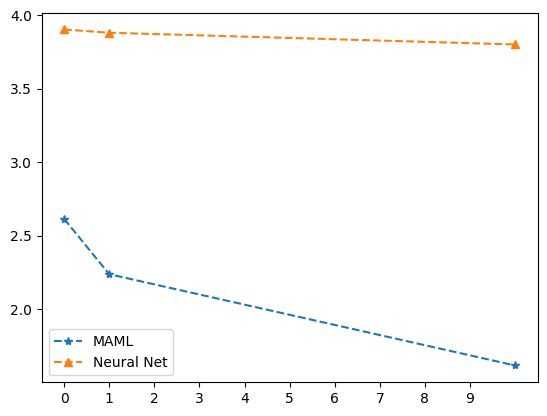





Neural Net


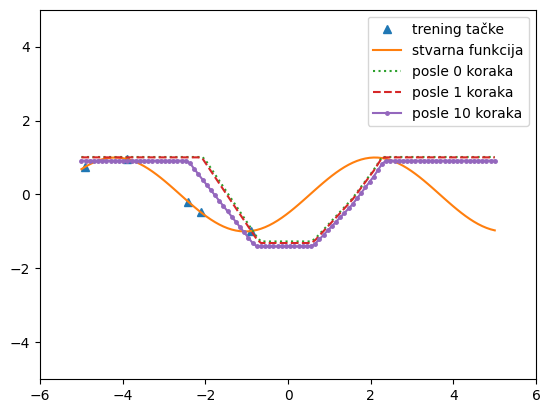

MAML


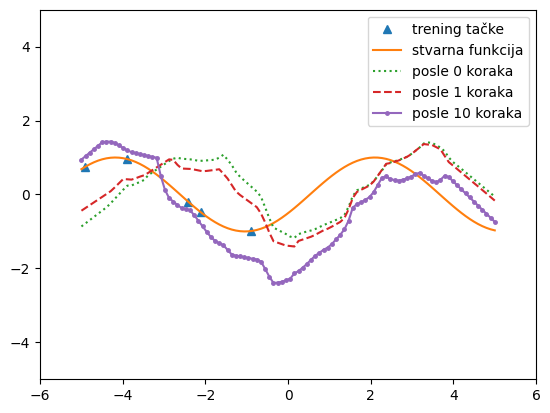

MSE comparison


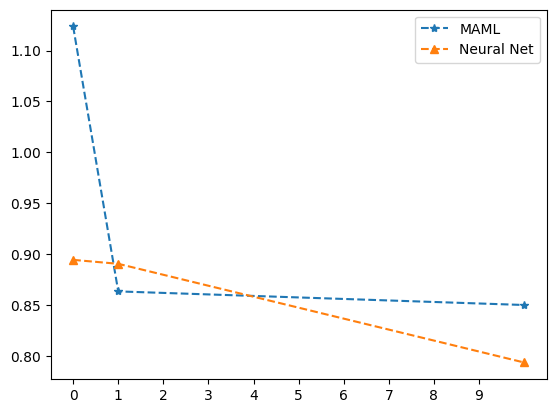





Neural Net


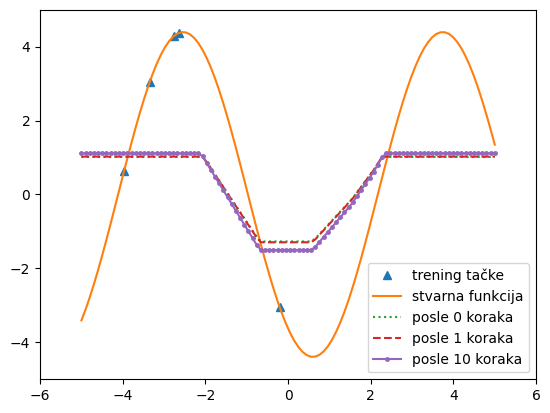

MAML


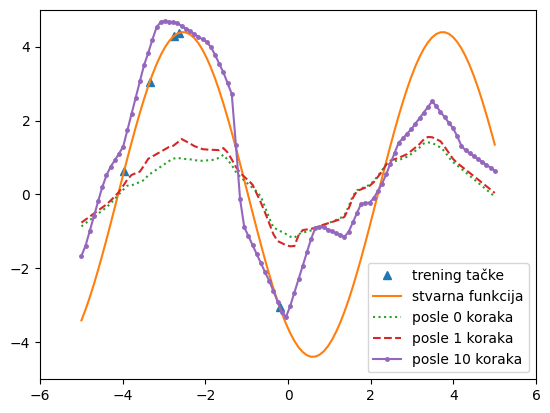

MSE comparison


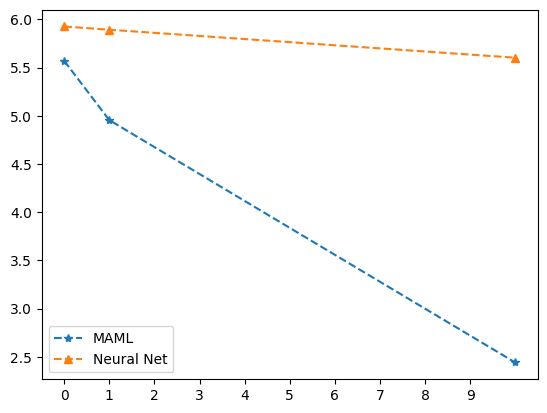





Neural Net


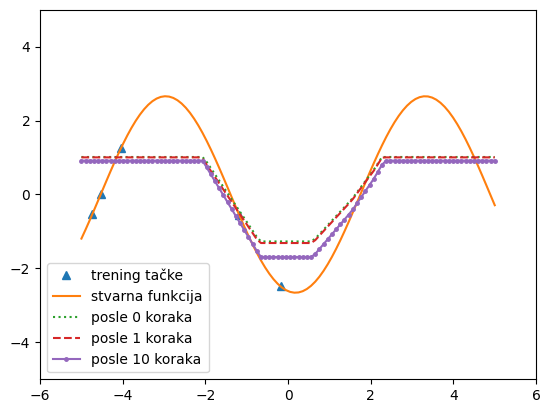

MAML


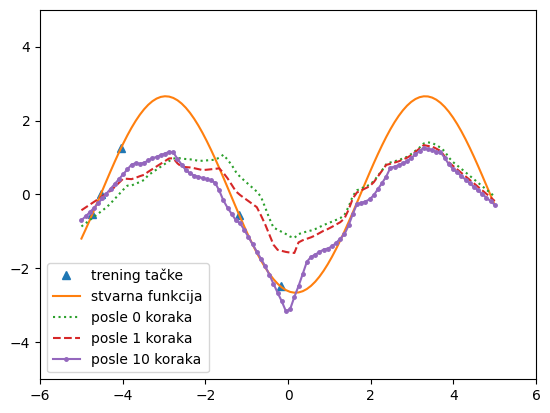

MSE comparison


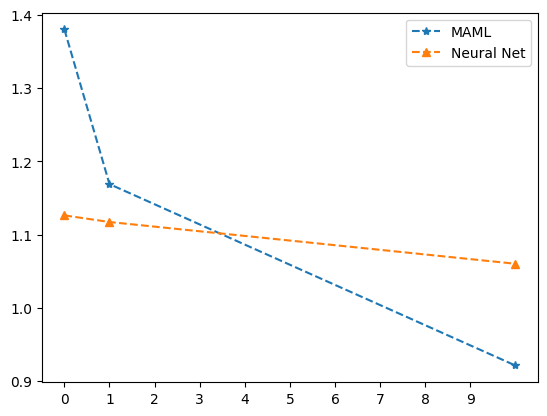





Neural Net


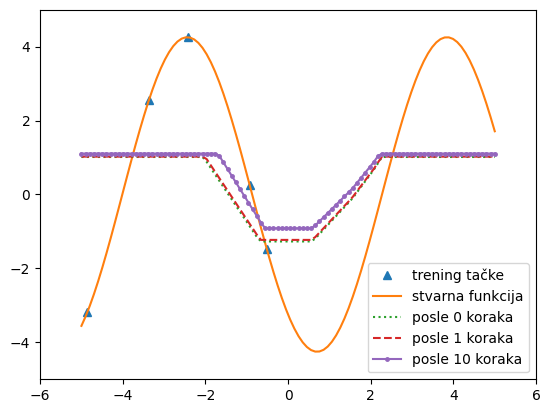

MAML


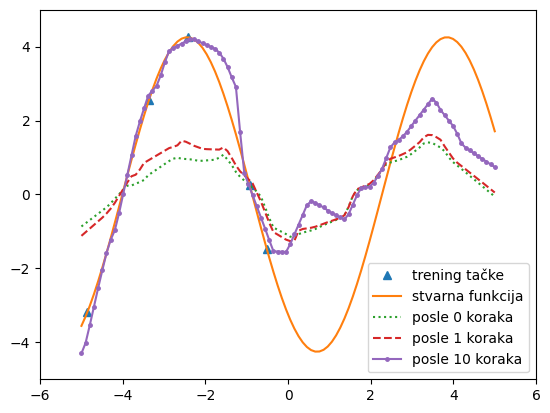

MSE comparison


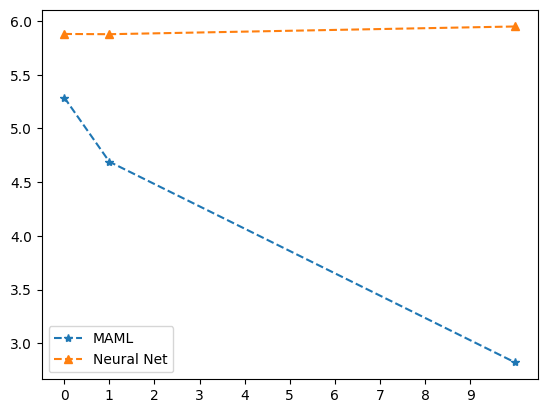





Neural Net


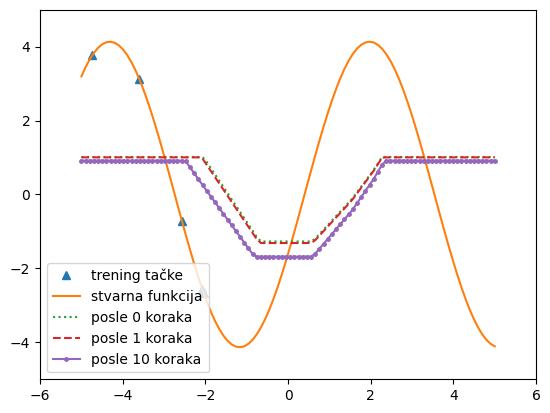

MAML


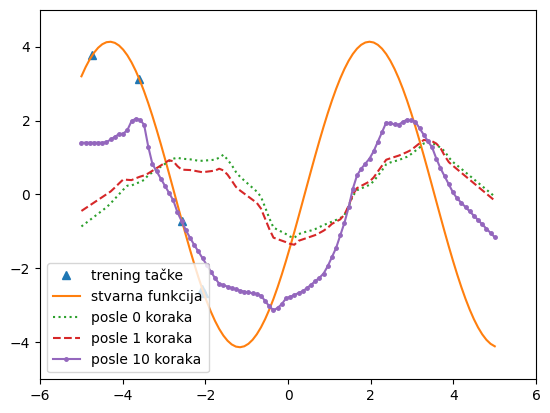

MSE comparison


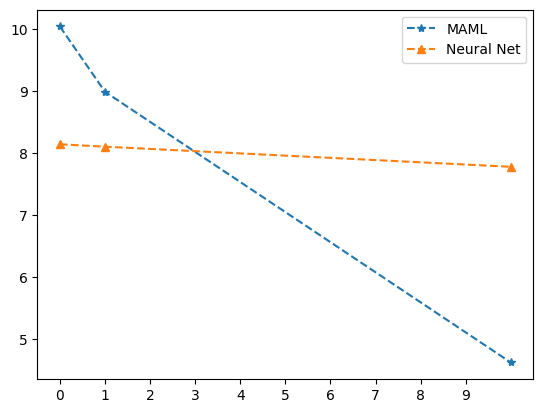





Neural Net


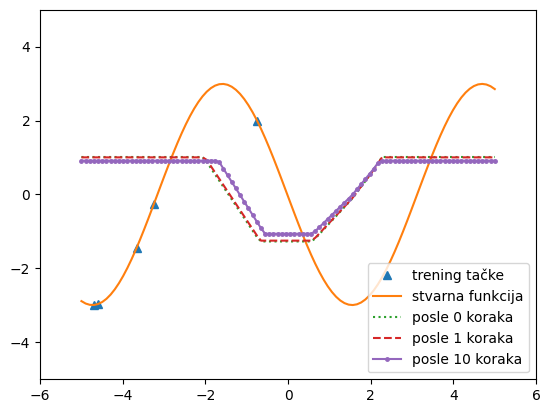

MAML


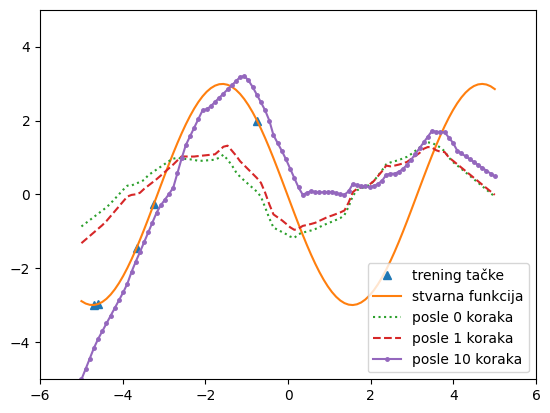

MSE comparison


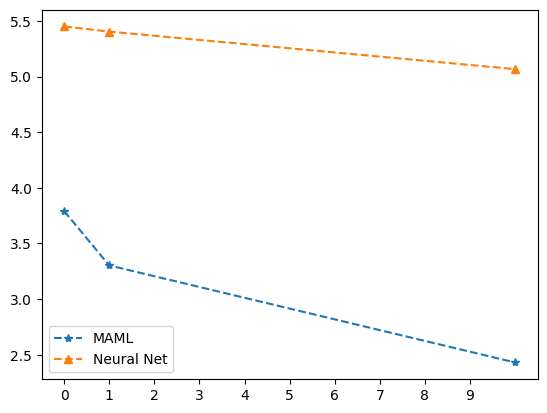





Neural Net


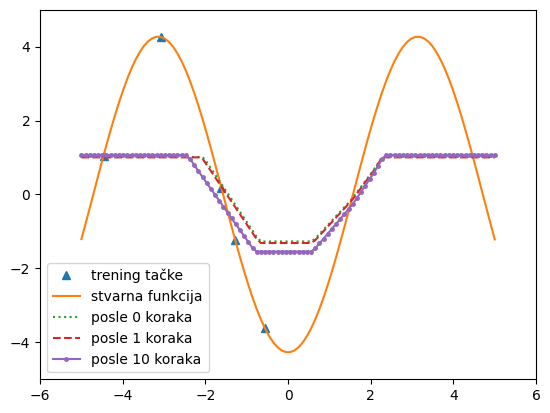

MAML


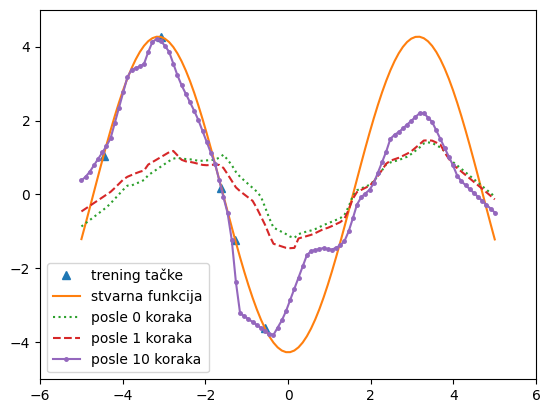

MSE comparison


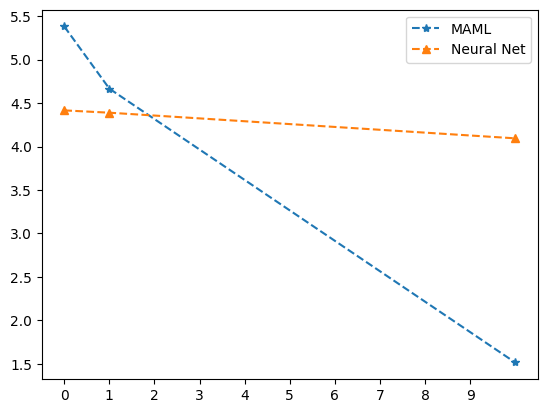





Neural Net


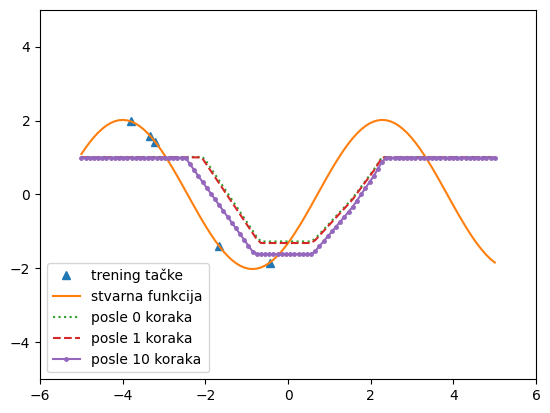

MAML


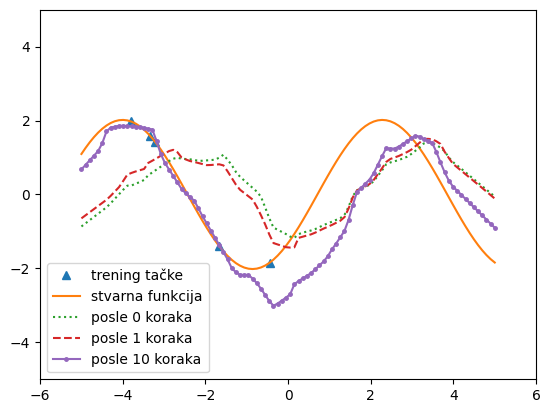

MSE comparison


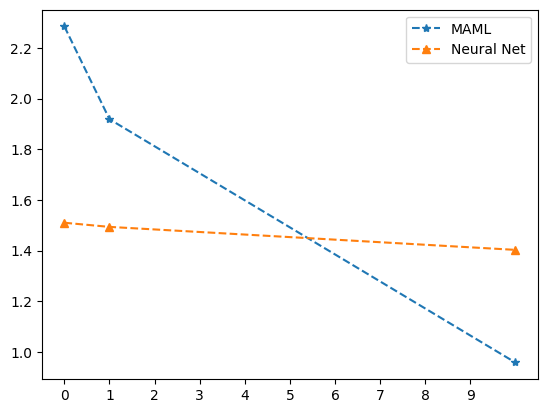





Neural Net


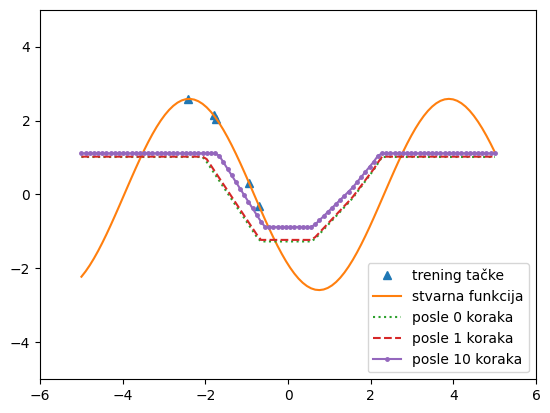

MAML


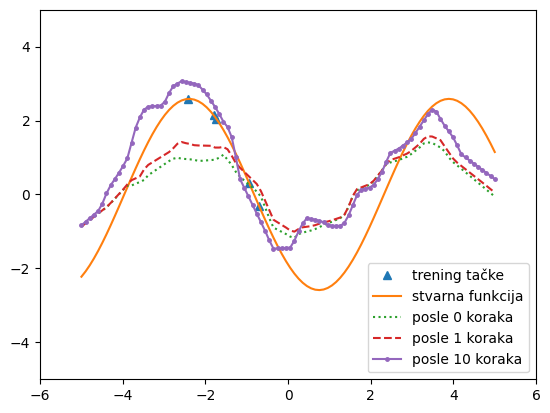

MSE comparison


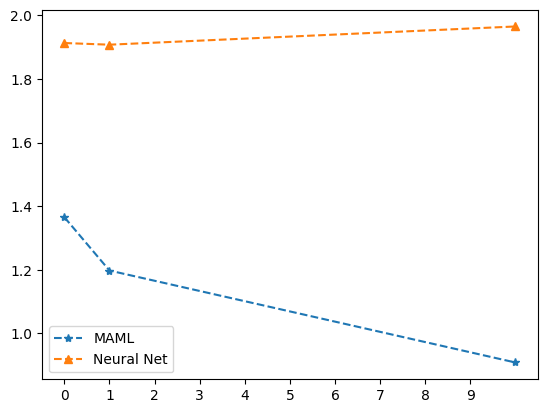

In [ ]:
for i in range(0, len(test_ds)):
  steps=[0,1,10]
  mft_nn = [torch.tensor(p.clone().detach().numpy(), requires_grad=True) for p in nn_params]
  mft_maml = [torch.tensor(p.clone().detach().numpy(), requires_grad=True) for p in maml_params]

  task_sample = test_ds[i].sample_task(K=10, side='left')

  tuned_nn, info_nn, x_nn, y_nn, x_test_nn, y_test_nn = tune_model(mft_nn, sine_wave=test_ds[i],
                                                                   sample=task_sample, max_steps=10)
  tuned_m, info_m, x_m, y_m, x_test_m, y_test_m = tune_model(mft_maml, sine_wave=test_ds[i],
                                                             sample=task_sample, max_steps=10)

  print("Neural Net")
  plot_tuned(info_nn, x_nn, y_nn, x_test_nn, y_test_nn)
  print("MAML")
  plot_tuned(info_m, x_m, y_m, x_test_m, y_test_m)
  print("MSE comparison")
  fit_res = {'MAML': info_m, 'Neural Net': info_nn}
  legend = []
  num_steps=list(range(10))
  markers = ['*', '^']
  ind=0
  for name in fit_res:
    x = []
    y = []
    for n, _, loss in fit_res[name]:
      if n in steps:
        x.append(n)
        y.append(loss)
    plt.plot(x, y, marker=markers[ind], linestyle='--')
    plt.xticks(num_steps)
    ind+=1
    legend.append(name)
  plt.legend(legend)
  plt.show()
  print()
  print()
  print()
  print()

Neural Net


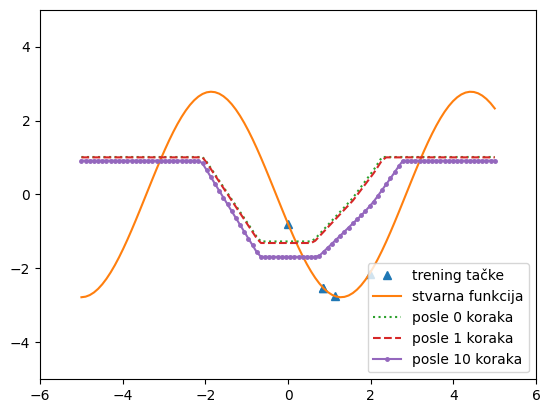

MAML


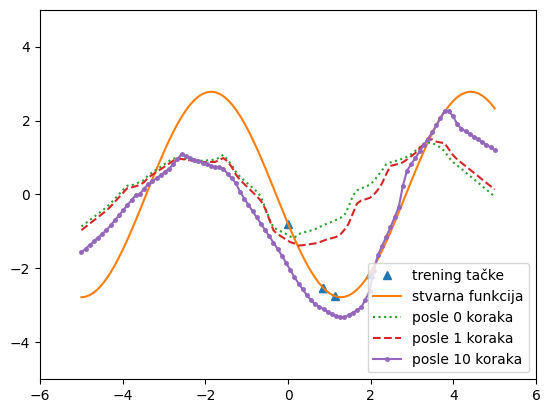

MSE comparison


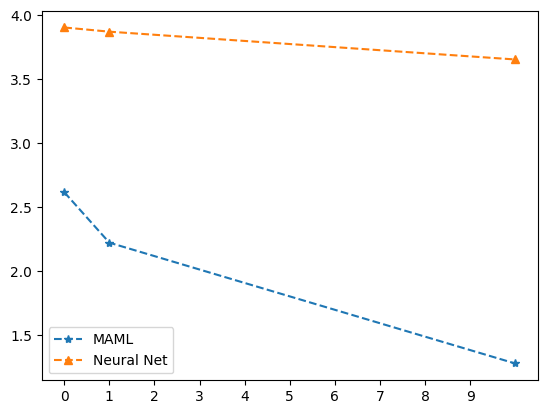





Neural Net


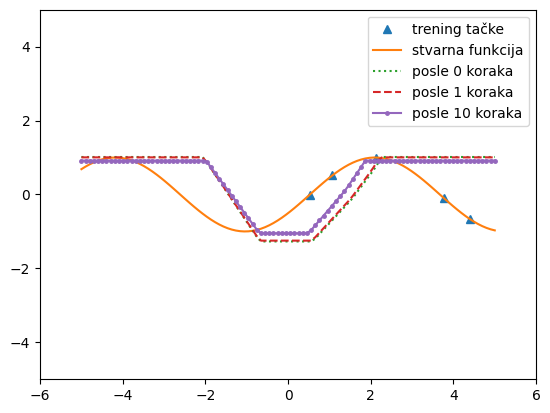

MAML


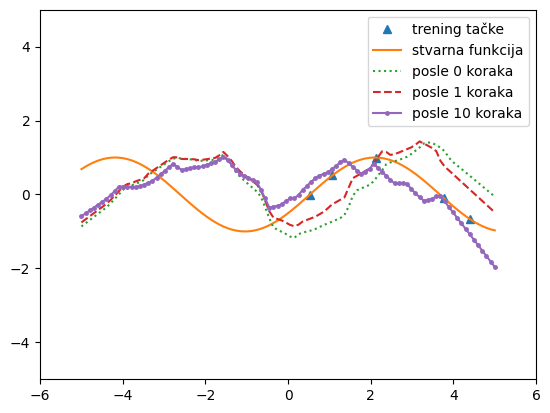

MSE comparison


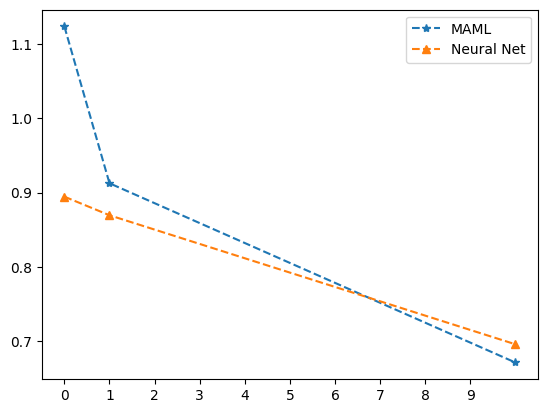





Neural Net


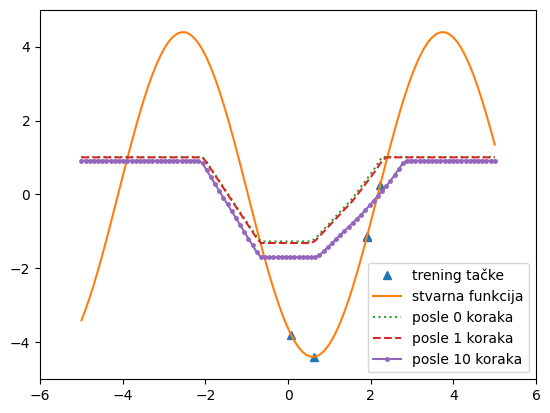

MAML


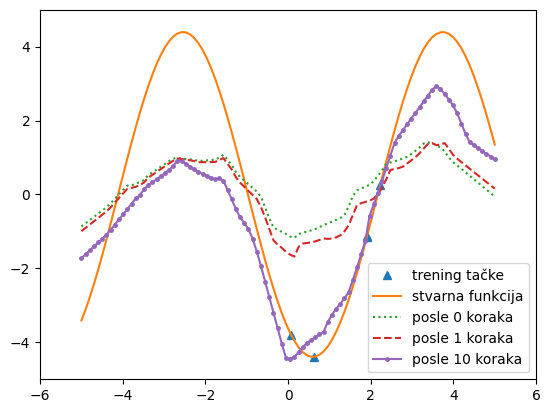

MSE comparison


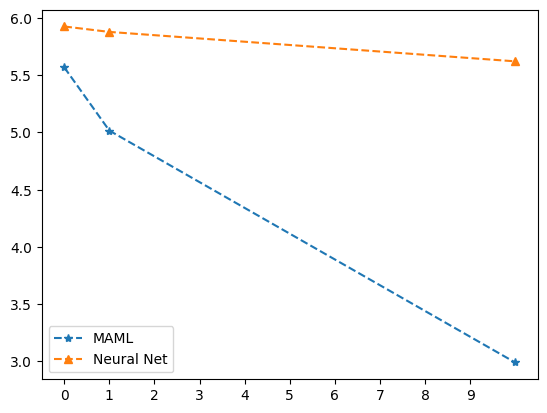





Neural Net


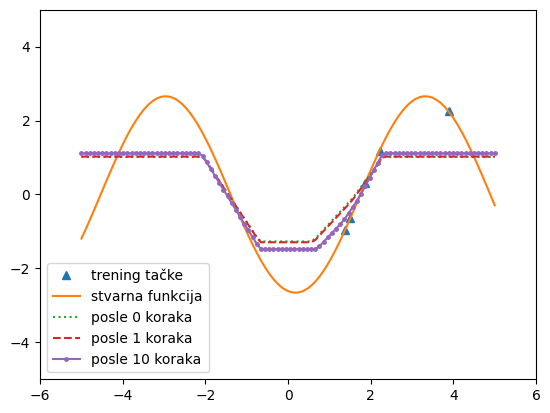

MAML


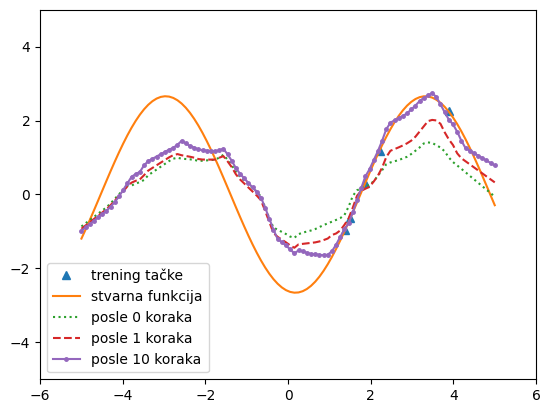

MSE comparison


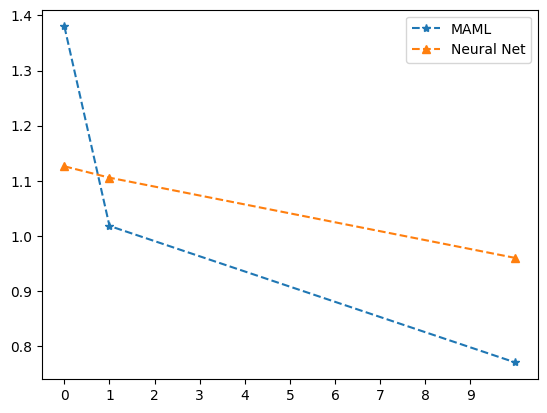





Neural Net


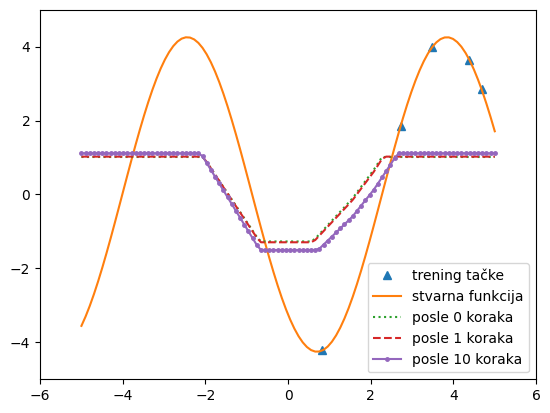

MAML


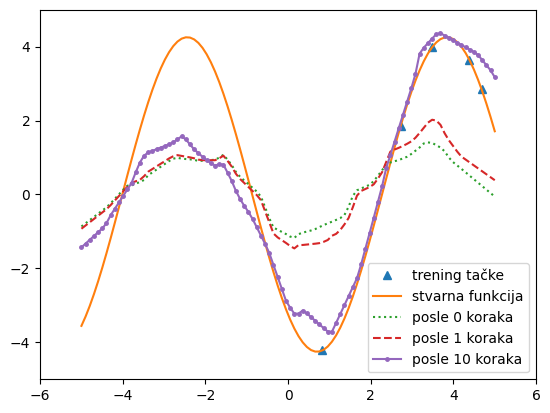

MSE comparison


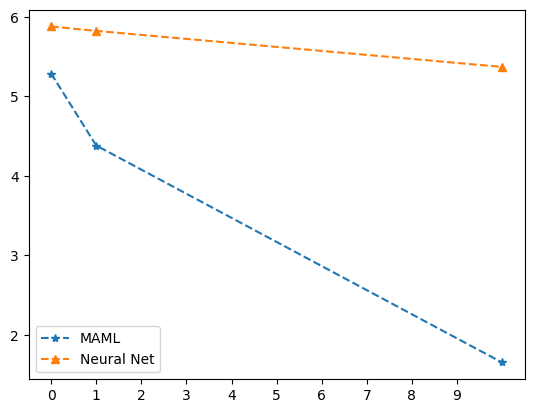





Neural Net


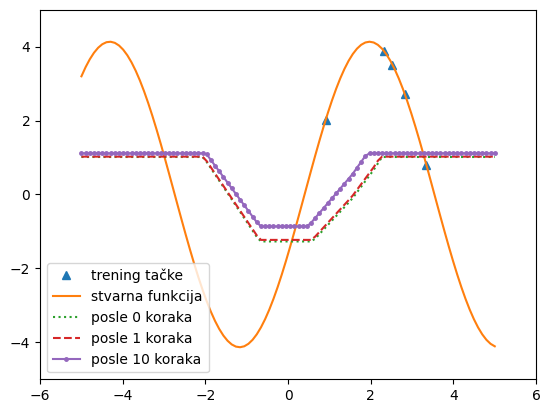

MAML


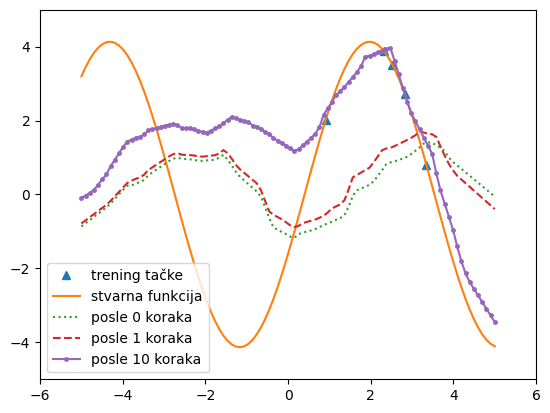

MSE comparison


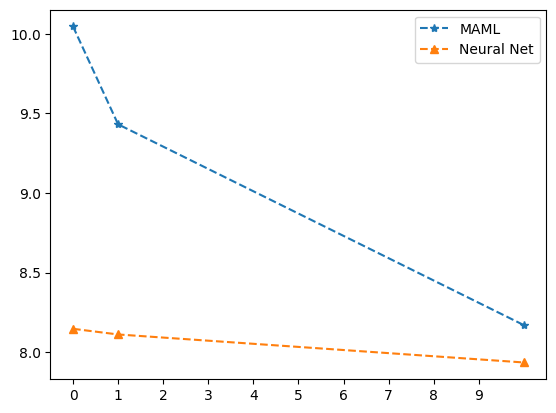





Neural Net


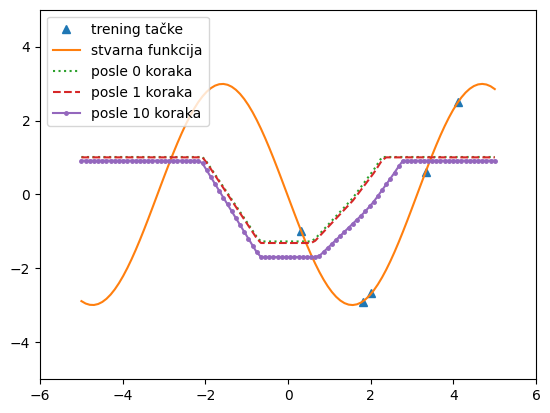

MAML


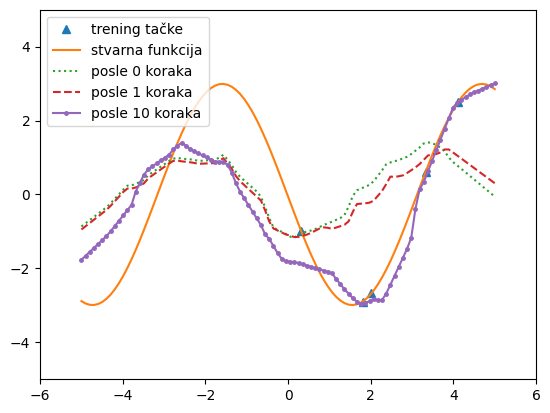

MSE comparison


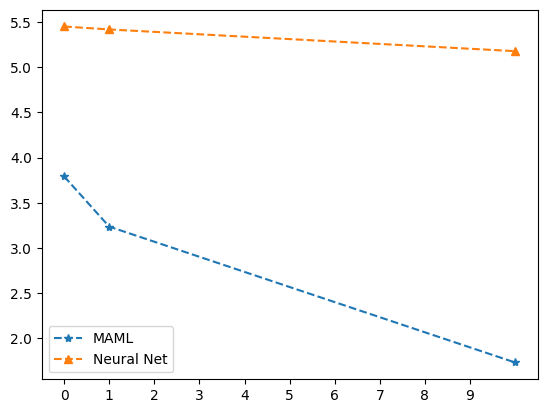





Neural Net


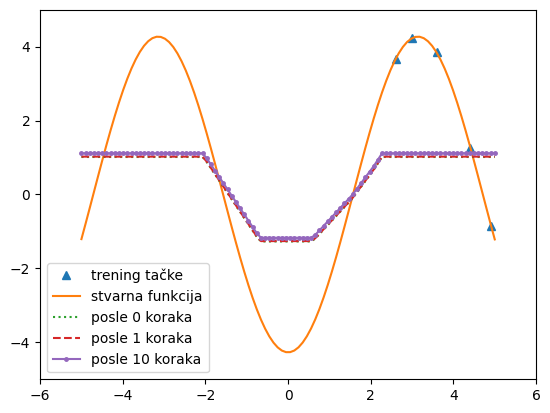

MAML


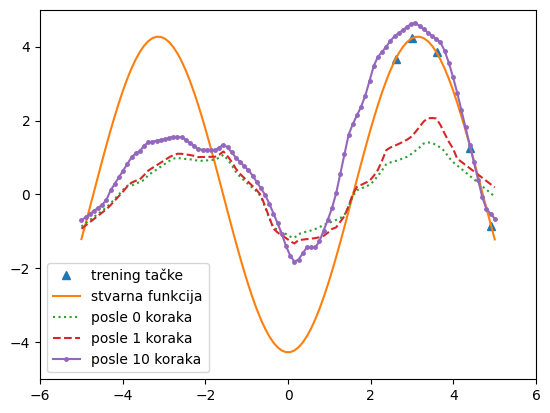

MSE comparison


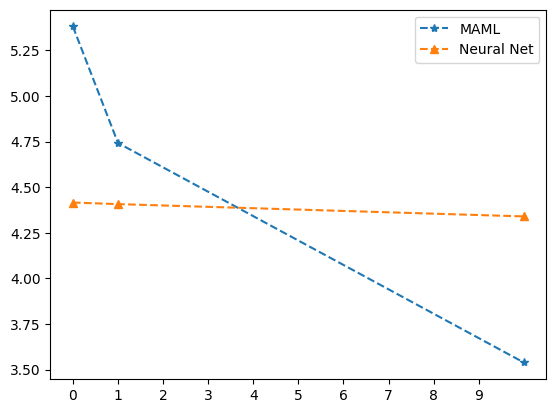





Neural Net


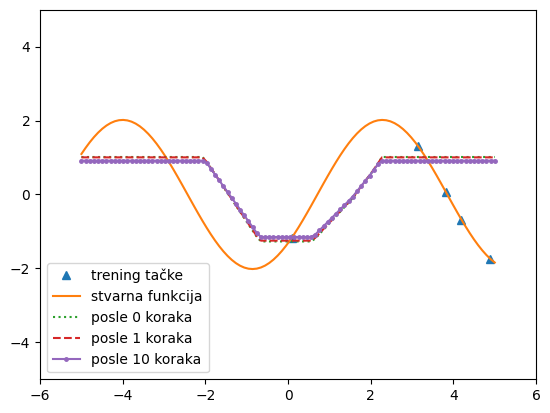

MAML


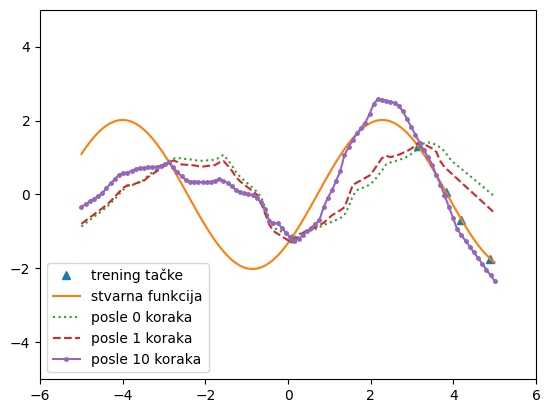

MSE comparison


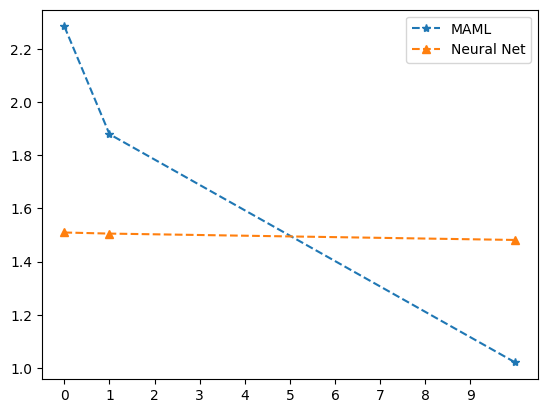





Neural Net


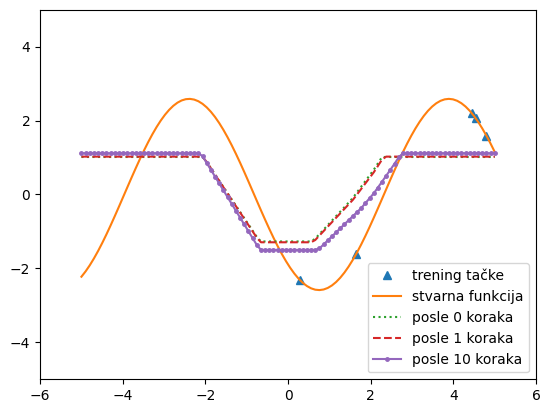

MAML


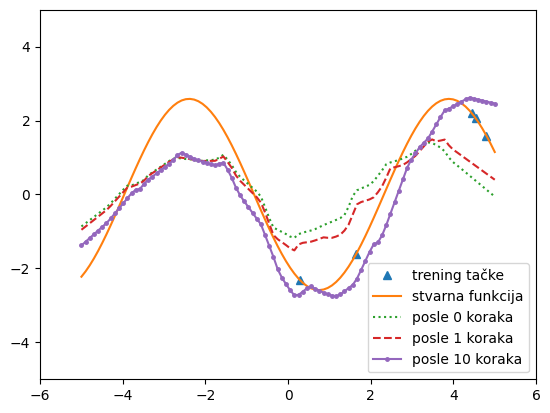

MSE comparison


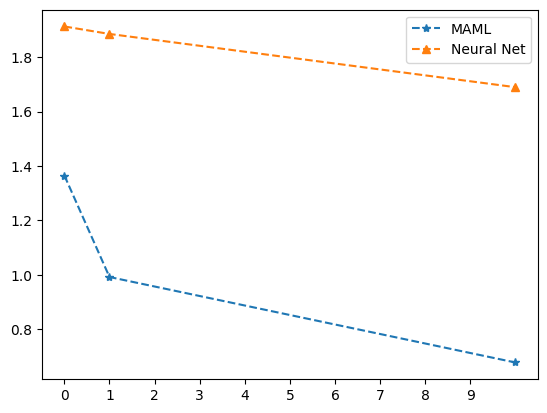

In [ ]:
for i in range(0, len(test_ds)):
  steps=[0,1,10]
  mft_nn = [torch.tensor(p.clone().detach().numpy(), requires_grad=True) for p in nn_params]
  mft_maml = [torch.tensor(p.clone().detach().numpy(), requires_grad=True) for p in maml_params]

  task_sample = test_ds[i].sample_task(K=10, side='right')

  tuned_nn, info_nn, x_nn, y_nn, x_test_nn, y_test_nn = tune_model(mft_nn, sine_wave=test_ds[i],
                                                                   sample=task_sample, max_steps=10)
  tuned_m, info_m, x_m, y_m, x_test_m, y_test_m = tune_model(mft_maml, sine_wave=test_ds[i],
                                                             sample=task_sample, max_steps=10)

  print("Neural Net")
  plot_tuned(info_nn, x_nn, y_nn, x_test_nn, y_test_nn)
  print("MAML")
  plot_tuned(info_m, x_m, y_m, x_test_m, y_test_m)
  print("MSE comparison")
  fit_res = {'MAML': info_m, 'Neural Net': info_nn}
  legend = []
  num_steps=list(range(10))
  markers = ['*', '^']
  ind=0
  for name in fit_res:
    x = []
    y = []
    for n, _, loss in fit_res[name]:
      if n in steps:
        x.append(n)
        y.append(loss)
    plt.plot(x, y, marker=markers[ind], linestyle='--')
    plt.xticks(num_steps)
    ind+=1
    legend.append(name)
  plt.legend(legend)
  plt.show()
  print()
  print()
  print()
  print()